In [52]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [49]:
zone = gpd.read_file('./data/containers_zone.json')

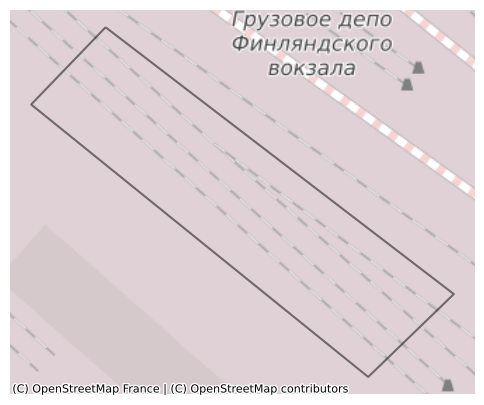

In [95]:
fig, ax = plt.subplots(figsize=(6, 12))
zone.to_crs(epsg=3857).plot(ax=ax, alpha=0.5, edgecolor='k')
ctx.add_basemap(ax=ax, zoom=18, source=ctx.providers.OpenStreetMap.France)
ax.axis('off');